In [1]:
import numpy as np
import scipy.stats as stats
##Library neural nets
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
# Library for Gaussian process
import GPy
##Library for visualization
import matplotlib as mpl
mpl.style.use("seaborn")
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
import pylab

/Users/liy0h/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [112]:
s.shape

(1000, 1)

In [257]:
N = 3000
d = 1
P = 1
X = np.array([np.ones(N)]).T ##Design matrix
np.random.seed(2)
s = np.random.uniform(high = 1, size=(N, d))
s = np.sort(s,axis=0)
pi = np.random.binomial(1,0.5,size=N)
y = np.sin(5 * s[:,0] + 0.7) * pi + (np.sin(8 * s[:,0]))*(1 - pi)
z = y + np.random.normal(0,0.2, size=N) * pi + (np.random.normal(0,0.3, size=N))*(1 - pi)
y = y.reshape(-1,1)
z = z.reshape(-1,1)

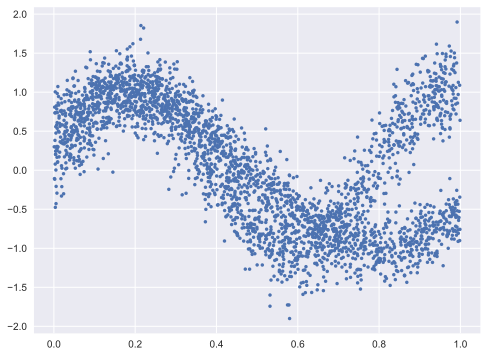

In [261]:
plt.plot(s,z,".")
plt.plot(s,y,"r")
plt.plot(s,z-y)

In [283]:
def create_mlp(feature_dim):
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim = feature_dim, kernel_initializer='normal', activation='elu'))##first hidden layer
    #RBFLayer(10,initializer=InitCentersRandom(X),betas=2.0,input_shape=(num_inputs,))
    model.add(Dense(100, activation='elu'))##second hidden layer
    model.add(Dense(100, activation='elu'))##third hidden layer
    model.add(Dense(1, activation='linear'))##outpur layer
    opt = Adam(lr=1e-3, decay=1e-3 / 200)
    # Compile model
    model.compile(loss='mse', optimizer=opt, metrics=['mse','mae'])
    return model

In [263]:
num_basis = [10,19,37,73]
knots = [np.linspace(0,1,i) for i in num_basis]
##Wendland kernel
K = 0 ## basis size
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/num_basis[res]*2.5
    for i in range(num_basis[res]):
        d = np.absolute(s-knots[res][i])/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + K] = 0
    K = K + num_basis[res]

In [264]:
from sklearn.model_selection import train_test_split
indices = np.arange(N)
## Split the training and testing sets
s_train, s_test, X_train, X_test, phi_train, phi_test\
    , z_train, z_test, idx_train, idx_test \
    = train_test_split(s, X, phi, z, indices, test_size=0.2)
N_train = s_train.shape[0]
N_test = s_test.shape[0]

In [409]:
model_3 = create_mlp(feature_dim = P + K)
XRBF_train = np.hstack((X_train,phi_train)) 
# train the model
print("[INFO] training model 3...")
train_history = model_3.fit(XRBF_train, z_train, validation_split = 0.2, epochs = 500, batch_size = 32, verbose = 0)

[INFO] training model 3...


In [266]:
##Warning: it is important to write 0:1 in GPRegression to get the size (Ntrain,1)
kernel = GPy.kern.Exponential(1,1,0.1) ##Covariance Function
m = GPy.models.GPRegression(s_train,z_train, kernel, noise_var = 0.1)
m.optimize()
mu_GP,var_GP = m.predict(s)
lo95_GP,up95_GP = m.predict_quantiles(s)
y_gp = mu_GP

In [412]:
XRBF = np.hstack((X,phi))
y_dk = model_3.predict(XRBF)

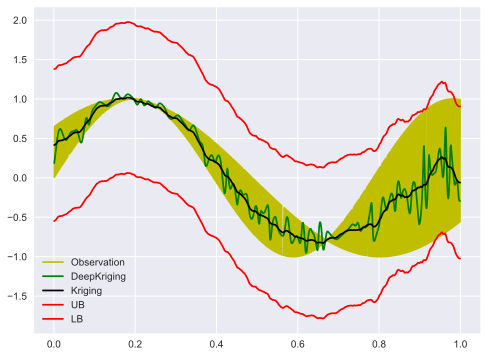

In [413]:
pylab.plot(s, y,"y",label="Observation")
pylab.plot(s, y_dk,'g',label="DeepKriging")
pylab.plot(s, y_gp,'black',label="Kriging")
pylab.plot(s, up95_GP,'red',label="UB")
pylab.plot(s, lo95_GP,'red',label="LB")
pylab.legend(loc='best')
pylab.show()

In [414]:
y_dk_test = model_3.predict(XRBF_test)
y_gp_test,var_GP = m.predict(s_test)
print(np.sqrt(np.mean((y_dk_test-z_test)**2)))
print(np.sqrt(np.mean((y_gp_test-z_test)**2)))

0.4899665822277812
0.48492210445380757


## Density estimation

In [51]:
import sys
sys.path.append('../')
from dcdr.deep_hist import Binning_CDF

In [300]:
from scipy.stats import iqr
init_seed = 1
bin_width = 2 * iqr(z_train)/(N**(1/3))
num_cut = int((z_train.max()-z_train.min())/bin_width)
hidden_list = [100,100,100]
dropout_list = [0.5,0.5,0.5]
histogram_bin = 'fixed'
loss_model = 'multi-binary'
seeding = 2

In [301]:
print(num_cut)

18


In [305]:
dcdr_model = Binning_CDF(num_cut=num_cut*10, hidden_list=hidden_list,
                         histogram_bin=histogram_bin, dropout_list=dropout_list,
                         seeding=seeding, loss_model=loss_model, 
                         niter=10)
    
dcdr_model.fit_cdf(XRBF_train, z_train, batch_size=32, merge_empty_bin=True, epochs = 500)

Train on 1920 samples, validate on 480 samples
Epoch 1/500
1920/1920 [==============================] - 12s 6ms/step - loss: 0.4307 - acc: 0.7858 - val_loss: 0.3575 - val_acc: 0.8584
Epoch 2/500
1920/1920 [==============================] - 0s 258us/step - loss: 0.3669 - acc: 0.8338 - val_loss: 0.2819 - val_acc: 0.8842
Epoch 3/500
1920/1920 [==============================] - 0s 250us/step - loss: 0.3151 - acc: 0.8661 - val_loss: 0.2479 - val_acc: 0.8863
Epoch 4/500
1920/1920 [==============================] - 0s 259us/step - loss: 0.2916 - acc: 0.8720 - val_loss: 0.2378 - val_acc: 0.8894
Epoch 5/500
1920/1920 [==============================] - 0s 259us/step - loss: 0.2798 - acc: 0.8785 - val_loss: 0.2348 - val_acc: 0.8891
Epoch 6/500
1920/1920 [==============================] - 1s 261us/step - loss: 0.2727 - acc: 0.8793 - val_loss: 0.2324 - val_acc: 0.8889
Epoch 7/500
1920/1920 [==============================] - 0s 258us/step - loss: 0.2702 - acc: 0.8787 - val_loss: 0.2321 - val_acc: 0.

In [310]:
up95_dpk=dcdr_model.predict_quantile(XRBF,quantiles=0.975)
lo95_dpk=dcdr_model.predict_quantile(XRBF,quantiles=0.025)

In [291]:
def density_func3(X, grid):  
    from scipy.stats import norm
    
    loc1 = np.sin(5* X[0] + 0.7)
    scale1 = 0.2
    
    loc2 = np.sin(8 * X[0])
    scale2 = 0.3
    
    rv1 = norm(loc=loc1, scale=scale1)
    rv2 = norm(loc=loc2, scale=scale2)
    return rv1.pdf(grid)*0.5 + rv2.pdf(grid)*0.5

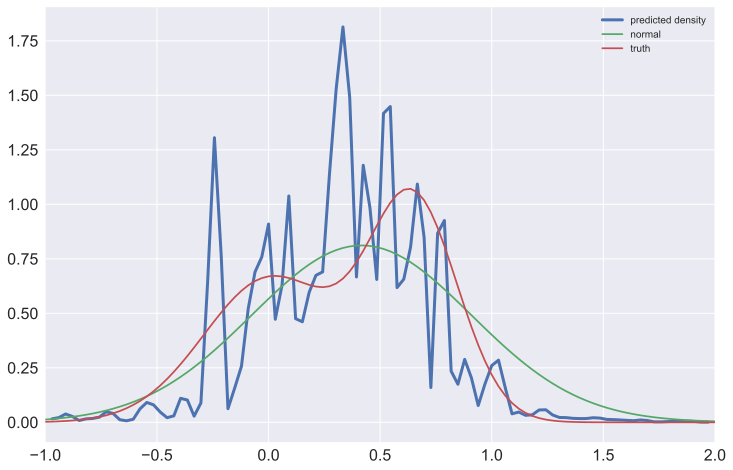

In [331]:
ref=1
grid = np.linspace(-1,2,100)
dcdr_model.plot_density(test_x = XRBF[ref,:],grid=grid)
pylab.plot(grid, stats.norm.pdf(grid, mu_GP[ref], np.sqrt(var_GP)[ref]),label="normal")
pylab.plot(grid, density_func3(s[ref],grid),label="truth")
pylab.legend(loc='best')
#pylab.show()
plt.savefig("density_sample.jpg")

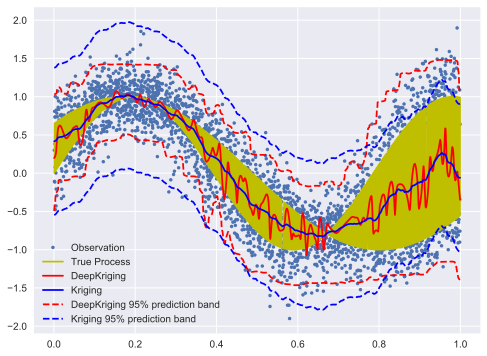

In [406]:
pylab.plot(s, z,".",label="Observation")
pylab.plot(s, y,"y",label="True Process")
pylab.plot(s, y_dk,'red',label="DeepKriging")
pylab.plot(s, mu_GP,'blue',label="Kriging")
plt.plot(s,up95_dpk,'r--',label="DeepKriging 95% prediction band")
plt.plot(s,lo95_dpk,'r--')
plt.plot(s,up95_GP,'b--',label="Kriging 95% prediction band")
plt.plot(s,lo95_GP,'b--')
#pylab.plot(s, mu+1,'black',label="GP")
pylab.legend(loc='best')
#pylab.show()
plt.savefig("1DMix_compare.pdf")

In [344]:
def Gaussian_CRPS(mu_test,sig_test,z_test):
    n = z_test.shape[0]
    crps = np.zeros(n)
    for i in range(n):
        pdf = stats.norm.pdf(z_test[i],loc=mu_test[i], scale=sig_test[i])
        cdf = stats.norm.cdf(z_test[i],loc=mu_test[i], scale=sig_test[i])
        scale_z = (z_test[i]-mu_test[i])/sig_test[i]
        crps[i] = sig_test[i]*(1/np.sqrt(np.pi)*2*pdf - scale_z*(2*cdf-1)
    return np.mean(crps)

In [345]:
z_test.shape

(600, 1)

In [415]:
XRBF_test = np.hstack((X_test,phi_test))
mu_GP_test,var_GP_test = m.predict(s_test)
dk_crps = dcdr_model.evaluate(XRBF_test, z_test, mode='CRPS')
Kriging_crps = Gaussian_CRPS(mu_GP_test,np.sqrt(var_GP),z_test)
quantiles = np.linspace(0.01, 0.99, num=99)
dcdr_aqtl = dcdr_model.evaluate(XRBF_test, z_test, quantiles=quantiles, mode='QuantileLoss')  

In [350]:
dk_crps

0.06022528843081059

In [351]:
Kriging_crps

0.06050130466399175

In [416]:
dcdr_aqtl

0.18754824844259477

In [403]:
def Gaussian_AQTL(s_test,z_test,quantiles):
    tau = quantiles.shape[0]
    aqtl = np.zeros(tau)
    for t in range(tau):
        aqtl[t] =np.mean((z_test -  m.predict_quantiles(s_test,quantiles[t:t+1])[0])*\
            (t- (z_test <=  m.predict_quantiles(s_test,quantiles[t:t+1])[0]))[0])    
    return np.mean(aqtl)

In [417]:
kriging_aqtl = Gaussian_AQTL(s_test, z_test, quantiles=quantiles)  

In [418]:
kriging_aqtl

61.71335578575979